In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import roc_auc_score, matthews_corrcoef, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

import time
import math
import random
from tqdm import tqdm
import regex as re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Import and Train-Test-Val-Split

In [27]:
train_df = pd.read_csv("Storage/Data/input_optimized.csv") 

train_df = train_df[['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']]
#train_df.columns = ['Unnamed: 0', 'patient_id', 'sequence','original', 'annotator_label']
train_df.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label
0,0,Z15564314,s other free text-see phs viewer social histor...,s other free text-see phs viewer Social Histor...,1
1,1,Z10171706,------- fusion: no sleep disturbance: no socia...,------- fusion: No Sleep disturbance: No Socia...,1
2,2,Z8935348,ain spasm). 30 tablet 0 unknown (outside pharm...,ain/spasm). 30 tablet 0 Unknown (outside pharm...,1
3,3,Z12212893,------- on 112mcg dose. maria will check dose ...,------- on 112mcg dose. Maria will check dos...,2
4,4,Z9598376,------- (vibramycin) 100 mg capsule take 1 cap...,------- (VIBRAMYCIN) 100 MG capsule Take 1 ca...,1


### 8050 - count of sequences with always pattern matches
### 606 - count of sequeunces w/o always pattern matches

### Train set - 8050 * 0.9 + 606 * 0.4 (7487)
### Validation Set - 8050 * 0.075 + 606 * .35 (816)
### Test Set - 8050 * 0.025 +  606 * .25 (353)

In [235]:
X = train_df[["patient_id","sequence"]]
y = train_df["annotator_label"]
print(len(X))

y_label = y.to_numpy()
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X,y,random_state=0,test_size=0.1, stratify=y_label)

y_test_valid_label = y_test_valid.to_numpy()
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, random_state=0, test_size=0.25, stratify=y_test_valid_label)

8050


In [236]:
y_test.value_counts()

1    113
0     52
2     37
Name: annotator_label, dtype: int64

In [237]:
manual_review = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\Data\test_and_validation.csv")

In [238]:
X_2 = manual_review[["patient_id","sequence"]]
y_2 = manual_review["annotator_label"]

y_label_2 = y_2.to_numpy()
X_train_2, X_test_valid_2, y_train_2, y_test_valid_2 = train_test_split(X_2,y_2,random_state=0,test_size=0.6, stratify=y_label_2)

y_test_valid_label_2 = y_test_valid_2.to_numpy()
X_valid_2, X_test_2, y_valid_2, y_test_2 = train_test_split(X_test_valid_2, y_test_valid_2, random_state=0, test_size=(0.25/0.6), stratify=y_test_valid_label_2)

In [239]:
X_train = X_train.append(X_train_2)
y_train = y_train.append(y_train_2)

X_test = X_test.append(X_test_2)
y_test = y_test.append(y_test_2)

X_valid = X_valid.append(X_valid_2)
y_valid = y_valid.append(y_valid_2)

In [242]:
X_train

,patient_id,sequence,label
3721,Z7805001,pleasant psychomotor: no abnormal movements st...,0
6945,Z8435677,unknown (outside pharmacy) • oseltamivir (tami...,1
3119,Z6738861,"------- 7), pulmonary emboli (2 27 2017), squa...",1
7444,Z11869179,------- e reminded of their traumatic experien...,2
2411,Z6545690,ately mental functions: arousal: intact orient...,0
...,...,...,...
556,Z12162077,"blet (1,000 mg total) by mouth 2 (two) times a...",1
96,Z7494405,"eck: no gross tracheal malpositioning, no jvd....",1
61,Z10019313,by discharge progressing • patient family care...,1
566,Z7574960,"------- es, hearing intact to conversation, sc...",1


In [241]:
X_train["label"] = y_train.to_list()

In [243]:
X_valid["label"] = y_valid.to_list()
X_test["label"] = y_test.to_list()

In [244]:
train = pd.concat([X_train, X_valid], axis = 0)
test = pd.concat([X_test])

In [248]:
train.to_csv(r"Storage\Data\train_full.csv", index = False)

In [249]:
test.to_csv(r"Storage\Data\test_full.csv", index = False)

### Having Solely Always pattern matches as part of train set and split 60% of manual-reviewed into validation and 40% into test (stratified across label)

In [622]:
X_train = train_df["sequence"]
y_train = train_df["annotator_label"]

In [690]:
# train_df[train_df["always_pattern_match"].str.len() == 0]

In [591]:
test_val_df = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\test_and_validation.csv")

In [595]:
X = test_val_df["sequence"]
y = test_val_df["annotator_label"]
y_label = y.to_numpy()

X_valid, X_test, y_valid, y_test = train_test_split(X,y,random_state=0,test_size=0.4, stratify=y_label)

## Additional Sampling to Obtain Optimal Data Sample

### Investigating why TFIDF vectors are combining words together

In [569]:
pattern = re.compile(r'attentionconcentration', re.IGNORECASE)

In [570]:
investigate = []
idxs = []
counter = 0
for seq in tqdm(train_df["sequence"]):
    m = pattern.search(seq)
    if (m != None):
        investigate.append(seq)
        idxs.append(counter)
        
#         specials = '-"/.~!' #etc
#         trans = seq.translate(str.maketrans(specials, ' '*len(specials)))
#         #print(trans)
#         train_df.loc[i]["sequence"] = trans
    counter += 1    

100%|██████████████████████████████████████████████████████████████████████████| 8656/8656 [00:00<00:00, 197791.93it/s]


In [573]:
idxs

[]

## Computing # of sequences that have always pattern matches to multiple classes

In [18]:
always_patterns = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\EDA\Data\always_patterns_8_1.csv")

In [19]:
always_pattern_regex = always_patterns["Pattern"].to_list()

In [20]:
for i in range(len(always_pattern_regex)):
    always_pattern_regex[i] = re.compile(always_pattern_regex[i], re.IGNORECASE)

In [21]:
df = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\BigDataSets\Regex_match\Diversity_Sampling\20K_sample_8_9.csv")

In [24]:
a = []
c = []
counter = 0

for seq in tqdm(train_df["original"]):
    curr = []
    classes = []
    conversion = {2: "Yes", 1 : "Neither", 0: "No"}
    
    for p in (always_pattern_regex):
        m = list(set(re.findall(p, seq)))
        m = list(set(map(str.lower, m)))
        if (m != []):
            curr.append("".join(m))
            label = int(train_df.loc[counter]['annotator_label'])
            classes.append(conversion[label])
            #classes = list(set(classes))
            
    a.append(curr)
    c.append(classes)
    counter += 1

train_df["always_pattern_match"] = a
train_df["always_pattern_classes"] = c

In [606]:
train_df.to_csv(r"input_with_always_and_without_8_1.csv", index = False)

In [580]:
train_df_optimal = train_df.drop(no_matches.index)

In [581]:
train_df_optimal["further_review"] = np.where((len(train_df_optimal["always_pattern_classes"]) > 1), 'N', 'Y')

In [582]:
further_review = train_df_optimal[train_df_optimal["further_review"] == 'Y']

In [583]:
further_review

,Unnamed: 0,patient_id,sequence,original,annotator_label,always_pattern_match,always_pattern_classes,further_review


In [585]:
train_df_optimal.to_csv(r"input_optimized.csv", index = False)

In [584]:
no_matches.to_csv(r"test_and_validation.csv", index = False)

### Computing Frequency per Keyword in dataset and comparing to overall 

In [429]:
regex = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\EDA\Getting_Data\keywords.csv")

In [430]:
k = regex["REGEX"].to_list()
c = regex["CASE"].to_list()
p_list = []

for i in range(len(k)):
    if (c[i] == 0):
        p_list.append(re.compile(k[i][5:], re.IGNORECASE))
    elif (c[i] == 1):
        p_list.append(re.compile(k[i]))
print(p_list)

[regex.Regex('\\bdementia\\b', flags=regex.I | regex.V0), regex.Regex('\\bcognition\\b', flags=regex.I | regex.V0), regex.Regex('\\bmemory\\b', flags=regex.I | regex.V0), regex.Regex('\\bMMSE\\b', flags=regex.I | regex.V0), regex.Regex('\\bMOCA\\b', flags=regex.I | regex.V0), regex.Regex('\\bAlzheimer\\b', flags=regex.I | regex.V0), regex.Regex('\\bcognitive\\s*impairment\\b', flags=regex.I | regex.V0), regex.Regex('(?-i:)\\bMCI\\b', flags=regex.V0), regex.Regex('\\bcerebellar\\b', flags=regex.I | regex.V0), regex.Regex('\\bNeurocognitive\\b', flags=regex.I | regex.V0), regex.Regex('\\blewy\\b', flags=regex.I | regex.V0), regex.Regex("\\bpick's\\b", flags=regex.I | regex.V0), regex.Regex('\\bCorticobasal\\b', flags=regex.I | regex.V0), regex.Regex('\\bcerebral\\b', flags=regex.I | regex.V0), regex.Regex('\\bcerebrovascular\\b', flags=regex.I | regex.V0), regex.Regex('\\bamnesia\\b', flags=regex.I | regex.V0), regex.Regex('(?-i:)\\bAD\\b', flags=regex.V0), regex.Regex('(?-i:)\\bLBD\\b',

In [433]:
l = []
for note in tqdm(train_df["original"]):
    curr = []
    for p in (p_list):
        m = list(set(re.findall(p, note)))
        m = list(set(map(str.lower, m)))
        if (m != []):
            curr.append("".join(m))
    #print(curr)
    #print(l)
    l.append(str(curr))
train_df["regex_match"] = l

100%|████████████████████████████████████████████████████████████████████████████| 8656/8656 [00:01<00:00, 5120.56it/s]


In [435]:
train_df.head()

,Unnamed: 0,patient_id,sequence,original,annotator_label,regex_match
0,0,Z7593118,nown patientreported discontinued atenolol ten...,nown (patient-reported) • [DISCONTINUED] ateno...,1,['alzheimer']
1,1,Z7236549,patricia was asked if she didnt tell the staff...,Patricia was asked if she didn't tell the sta...,0,['memory']
2,2,Z6712628,ission note patient theodore buck mrn 04176434...,------- ission Note Patient: Theodore Buck MR...,1,['alzheimer']
3,3,Z12234642,extr warm and well perfused no evidence of ede...,"------- Extr: Warm and well perfused, no evi...",0,"['memory', 'cerebellar']"
4,4,Z7691325,e once a week enjoys travel goes to italy once...,"e once a week! Enjoys travel, goes to Italy on...",1,['alzheimer']


In [438]:
train_df.loc[i]['regex_match']

"['alzheimer']"

In [469]:
cols =  ['dementia', 'cognition',"\'cognition", 'memory', "memory\'", 'cdr', 'mmse', 'moca', 'alzheimer', 'cognitive impairment','cognitiveimpairment', 'mci', 'cerebellar', 'neurocognitive', 'lewy', "pick's", 'cortical', 'corticobasal', 'cerebral', 'cerebrovascular', 'amnesia', 'ad', 'lbd']
summary_stats  = pd.DataFrame(pd.np.empty((len(train_df), len(cols))) * pd.np.nan) 
summary_stats.columns = cols

In [466]:
for i in tqdm(range(len(train_df))):
    keyword_list = list(eval(train_df.loc[i]['regex_match']))
    #print(keyword_list, len(keyword_list))
    match_tuples = []
    for j in range(len(keyword_list)):
        x = keyword_list[j]

        match_tuples.append((x, 0))

    #print(match_tuples)

    freq = {"dementia":0
        ,"cognition":0
        ,"\'cognition":0
        ,"memory":0
        ,"memory\'":0
        ,"cdr":0
        ,"mmse":0
        ,"moca":0
        ,"alzheimer":0
        ,'cognitive impairment':0
        , "cognitiveimpairment":0
        ,"mci":0
        ,"cerebellar":0
        ,"neurocognitive":0
        ,"lewy":0
        ,"pick's":0
        ,"cortical":0
        ,"corticobasal":0
        ,"cerebral":0
        ,"cerebrovascular":0
        ,"amnesia":0
        ,'ad':0
        ,'lbd':0
    }

    for k, v in match_tuples:   
        if (k != ''):
            freq.update({str(k.lower()):int(freq[k.lower()] + 1)})

    #print(freq, "\n")

    #summary_stats["encounters_with_keywords"][i] = len(train_df[train_df["PatientID"] == unique_ids[i]])

    for k, v in freq.items():
        summary_stats[str(k.lower())][i] = int(v)

100%|█████████████████████████████████████████████████████████████████████████████| 8656/8656 [00:26<00:00, 329.07it/s]


In [467]:
summary_stats.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Optimizing-data\keywords_distribution_train_set_8_1.csv", index = False)

## Count-Vectorizer

In [109]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
count_valid = count_vectorizer.transform(X_valid)
count = count_vectorizer.transform(X)

# Create the CountVectorizer DataFrame: count_train
count_train = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_test = pd.DataFrame(count_test.A, columns=count_vectorizer.get_feature_names())
count_valid = pd.DataFrame(count_valid.A, columns=count_vectorizer.get_feature_names())
count = pd.DataFrame(count.A, columns=count_vectorizer.get_feature_names())
count.head()

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zupon,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF-Vectorizer

In [110]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english",analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')
tfidf_train= tfidf_vectorizer.fit_transform(X_train)
tfidf_valid = tfidf_vectorizer.transform(X_valid)
tfidf_test = tfidf_vectorizer.transform(X_test)
tfidf = tfidf_vectorizer.transform(X)

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_valid = pd.DataFrame(tfidf_valid.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_test = pd.DataFrame(tfidf_test.A, columns=tfidf_vectorizer.get_feature_names())
tfidf = pd.DataFrame(tfidf.A, columns=tfidf_vectorizer.get_feature_names())
tfidf.head()

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zupon,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.106654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparing Data for SMOTE

In [34]:
#ONLY run once
tfidf_train_features_df = pd.concat([tfidf_train, y_train.reset_index(drop=True)], axis=1)
tfidf_test_features_df = pd.concat([tfidf_test, y_test.reset_index(drop = True)], axis = 1)
tfidf_valid_features_df = pd.concat([tfidf_valid, y_valid.reset_index(drop = True)], axis = 1)

In [312]:
tfidf_train_features_df_data = tfidf_train_features_df.values
X_smote, y_smote = tfidf_train_features_df_data[:, :-1], tfidf_train_features_df_data[:, -1]

tfidf_test_features_df_data = tfidf_test_features_df.values
X_smote_test, y_smote_test = tfidf_test_features_df_data[:, :-1], tfidf_test_features_df_data[:, -1]

tfidf_valid_features_df_data = tfidf_valid_features_df.values
X_smote_valid, y_smote_valid = tfidf_valid_features_df_data[:, :-1], tfidf_valid_features_df_data[:, -1]

In [35]:
X_train_new = pd.DataFrame(X_train)
y_train_new = pd.Series(y_train)

X_test_new = pd.DataFrame(X_test)
y_test_new = pd.Series(y_test)

X_valid_new = pd.DataFrame(X_valid)
y_valid_new = pd.Series(y_valid)

In [36]:
x = list(tfidf_train_features_df.columns) 
x.append('annotator_label')
len(x)

23674

In [37]:
X_train_new

,sequence
3721,pleasant psychomotor: no abnormal movements st...
6945,unknown (outside pharmacy) • oseltamivir (tami...
3119,"------- 7), pulmonary emboli (2 27 2017), squa..."
7444,------- e reminded of their traumatic experien...
2411,ately mental functions: arousal: intact orient...
...,...
556,"blet (1,000 mg total) by mouth 2 (two) times a..."
96,"eck: no gross tracheal malpositioning, no jvd...."
61,by discharge progressing • patient family care...
566,"------- es, hearing intact to conversation, sc..."


In [38]:
tfidf_train_features_df_new = tfidf_train_features_df #pd.concat([tfidf_train_features_df, y_train_new.reset_index(drop = True)], axis = 1)#pd.concat([X_train_new, y_train_new.reset_index(drop=True)], axis=1)
tmp = list(tfidf_train_features_df.columns) 
tfidf_train_features_df_new.columns = tmp

tfidf_test_features_df_new = tfidf_test_features_df #pd.concat([tfidf_test_features_df, y_test_new.reset_index(drop = True)], axis = 1)#pd.concat([X_test_new, y_test_new.reset_index(drop=True)], axis=1)
tmp2 = list(tfidf_test_features_df.columns) 
tfidf_test_features_df_new.columns = tmp2

tfidf_valid_features_df_new = tfidf_valid_features_df #pd.concat([tfidf_valid_features_df, y_valid_new.reset_index(drop = True)], axis = 1)#pd.concat([X_valid_new, y_valid_new.reset_index(drop=True)], axis=1)
tmp3 = list(tfidf_valid_features_df.columns) 
tfidf_valid_features_df_new.columns = tmp3

In [39]:
mappings = {0.0 : 0, 1.0 : 1, 2.0 : 2}

tfidf_train_features_df_new.annotator_label = [mappings[item] for item in tfidf_train_features_df_new.annotator_label]
tfidf_test_features_df_new.annotator_label = [mappings[item] for item in tfidf_test_features_df_new.annotator_label]
tfidf_valid_features_df_new.annotator_label = [mappings[item] for item in tfidf_valid_features_df_new.annotator_label]

tfidf_features_master = pd.concat([tfidf_train_features_df_new,tfidf_test_features_df_new,tfidf_valid_features_df_new])

tfidf_features_master.head()

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness,annotator_label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.052681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [40]:
cross_validation = pd.concat([tfidf_train_features_df_new,tfidf_valid_features_df_new])
len(cross_validation), cross_validation.shape

(8302, (8302, 23673))

In [41]:
tfidf_train_features_df_new.drop(columns = 'annotator_label')
tfidf_test_features_df_new.drop(columns = 'annotator_label')
tfidf_valid_features_df_new.drop(columns = 'annotator_label')

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zupon,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,0.032173,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
812,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813,0.000000,0.057651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
tfidf_train_features_df_new

,0,00,000,0000,0001,0005,0009,000u,0015,001698,...,zurek,zydis,zyflo,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness,annotator_label
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.052681,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,0.089235,0.0,0.096752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7483,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7484,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7485,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [43]:
full_tfidf = pd.concat([tfidf_train_features_df_new, tfidf_test_features_df_new, tfidf_valid_features_df_new])

## Filtering by Pearson Correlation Coefficient

In [44]:
def filter_features_by_cor(df):
    m = len(df.columns)
    output = df.iloc[:,m-1] 
    output_list = output.tolist()
    corrcoef_array = []

    for i in range(0,m-2):
        input_list = df.iloc[:,i].tolist()
        cols = [input_list, output_list]
        corrcoef = abs(np.corrcoef(cols)) 
        corrcoef_array = np.append(corrcoef_array,corrcoef[0,1])

    feature_names = list(df)
    feature_names = feature_names[0:m-2]
    
    output_df = pd.DataFrame(feature_names, columns=['Features'])
    output_df['CorrCoef'] = corrcoef_array
    output_df = output_df.sort_values('CorrCoef')
    output_df = output_df.reset_index()
    output_df = output_df.drop(columns = "index")
    
    return output_df

In [45]:
tfidf_output_df = filter_features_by_cor(tfidf_train_features_df)
tfidf_output_df = tfidf_output_df.sort_values(by=['CorrCoef'],ascending = False)

In [46]:
tfidf_output_df.head(10)

,Features,CorrCoef
23670,intact,0.573524
23669,oriented,0.435062
23668,concentration,0.428464
23667,orientation,0.413392
23666,perceptions,0.407123
23665,sensorium,0.407021
23664,judgment,0.396873
23663,fund,0.383888
23662,experiences,0.379740
23661,ideation,0.371309


In [777]:
tfidf_output_df.to_csv('Data/tfidf_vector_feature_corr_8_1.csv', index = False)

In [778]:
# Setting Correlation threshold
top_tfidf_features_df = tfidf_output_df[:500]
filtered_tfidf_train = tfidf_train_features_df_new.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_test = tfidf_test_features_df_new.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_valid   = tfidf_valid_features_df_new.filter(items=top_tfidf_features_df['Features'])
#filtered_tfidf_tanish = tfidf_tanish.filter(items = top_tfidf_features_df['Features'])

In [277]:
filtered_tfidf_train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\tfidf_train_smote.csv", index = False)
filtered_tfidf_test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\tfidf_test_smote.csv", index = False)
filtered_tfidf_valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\tfidf_validation_smote.csv", index = False)

In [278]:
y_train.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\y_train_smote.csv", index = False)
y_test.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\y_test_smote.csv", index = False)
y_valid.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\y_validation_smote.csv", index = False)

## Finding Optimal Correlation Threshold Value by running Logistic Regression model on Validation Set

In [48]:
def filter_by_corr(corr, tfidf_output_df):
    # Setting Correlation threshold
    top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
    filtered_tfidf_train = tfidf_train_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
    filtered_tfidf_valid = tfidf_valid_features_df.filter(items=top_tfidf_features_df['Features'])
    
    return top_tfidf_features_df, filtered_tfidf_train, filtered_tfidf_test, filtered_tfidf_valid

In [54]:
def logisitic_regression(X_train, y_train, X_test, y_test, c, want_report, want_conf_mat, testing = False):
    # fitting model
    lr = LogisticRegression(penalty='l1', solver='liblinear', C = c, random_state=0)
    lr.fit(X_train, y_train)
    
    if (testing):
        filename = 'Storage/lr_8_9.sav'
        pickle.dump(lr, open(filename, 'wb'))
    
    # predictions
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)
    
    #print(y_pred, y_prob)
    
    # collecting results
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovr')
    
    if (want_report == True):
        target_names = ['NO', 'NTR', 'YES']
        results_lgr = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
        results_lgr = pd.DataFrame(results_lgr).transpose()
        
        if (want_conf_mat == True):
            return lr, acc, auc, c, results_lgr, confusion_matrix(y_test, y_pred)
    
        return lr, acc, auc, c, results_lgr
    
    if (want_conf_mat == True):
        return lr, acc, auc, c, confusion_matrix(y_test, y_pred)
        
    return lr, acc, auc, c

## Cross Validation

In [55]:
def cross_validation_split(dataset, n_folds):
    # ensuring straftification across label
    yes = cross_validation[cross_validation["annotator_label"] == 2].reset_index(drop = True)
    no = cross_validation[cross_validation["annotator_label"] == 0].reset_index(drop = True)
    ntr = cross_validation[cross_validation["annotator_label"] == 1].reset_index(drop = True)
    #print(len(yes), len(no), len(ntr))
    
    yes_count = len(yes) // 10
    no_count = len(no) // 10
    ntr_count = len(ntr) // 10
    #print(yes_count, no_count, ntr_count)
    split = list()
    fold_size = len(cross_validation) // 10

    # shuffling data to avoid having to generate random nums through while loop
    yes = yes.sample(frac=1).reset_index(drop=True)
    no = no.sample(frac=1).reset_index(drop=True)
    ntr = ntr.sample(frac=1).reset_index(drop=True)
    
    # creating folds
    for i in tqdm(range(n_folds)):
        fold = pd.DataFrame(columns = cross_validation.columns)

        fold = fold.append(yes[yes_count * i : (yes_count * i) + yes_count])
        #print(len(fold), "YES", )
        fold = fold.append(no[no_count * i : (no_count * i) + no_count])
        #print(len(fold), "NO", )
        fold = fold.append(ntr[ntr_count * i : (ntr_count * i) + ntr_count])
        #print(len(fold), "NTR", ((ntr_count * i) + ntr_count) - (ntr_count * i))
        split.append(fold)
        
    return split

In [56]:
cross_validation = cross_validation.reset_index(drop = True)

In [961]:
splits = cross_validation_split(cross_validation, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


In [922]:
#cross_validation.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Data\cross_validation_tfidf_8_3.csv", index = False)

In [57]:
def evaluate_algorithm(dataset, n_folds):
    splits = cross_validation_split(dataset, n_folds)
    
    counter = 0
    tfidf_all_df = pd.DataFrame()
    df_list  = []
    
    for fold in splits:
        train = splits.copy()
        del train[counter]
        train = pd.concat(train)
        
        y_train = train["annotator_label"].reset_index(drop = True)
        y_train = y_train.astype(int)
        
        y_test = fold["annotator_label"].reset_index(drop = True)
        y_test = y_test.astype(int)
        
        train = train.drop(columns = ["annotator_label"])
        fold = fold.drop(columns = ["annotator_label"])
        
        test = list()
        corr_list = list(np.arange(1,30) * 0.01)
       
        for corr in corr_list:
            acc_list = []
            auc_list = []
            c_list = []
             
            # filtering by correlation coefficient
            top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
            filtered_tfidf_train = train.filter(items=top_tfidf_features_df['Features'])
            filtered_tfidf_fold = fold.filter(items=top_tfidf_features_df['Features'])
            filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])
            
            #print(filtered_tfidf_train.shape)
            #print(filtered_tfidf_fold.shape)
            
            # tuning for optimal lambda value
            for c in [0.01, 0.1, 1, 10, 100]:
                lr, acc, auc, c = logisitic_regression(filtered_tfidf_train, y_train, filtered_tfidf_fold, y_test, c, False, False, False)
                acc_list.append(acc)
                auc_list.append(auc)
                c_list.append(c)
            
            # gathering model stats
            acc_df = pd.DataFrame(acc_list, columns=['acc'])
            auc_df = pd.DataFrame(auc_list, columns=['auc'])
            c_df = pd.DataFrame(c_list, columns=['c_value'])
            
            assert len(acc_df) == len(auc_df) == len(c_df)
            
            #acc_df["fold_number"] = auc_df["fold_number"] = c_df["fold_number"] = [counter] * len(auc_df)
            
            iter_df = pd.concat([c_df, acc_df, auc_df], axis=1)
            iter_df['corr_thres'] = [corr] * len(iter_df)
            iter_df['fold_number'] = [(counter + 1)] * len(iter_df)
            df_list.append(iter_df)
            
        print("Completed Fold #: ", counter + 1)
        counter += 1
        
        print("Stats DF has", len(df_list), "records")
        
        #df_list.to_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Optimizing-data\sample_stat_df.csv", index = False)
    return df_list

In [58]:
tfidf_all_df = evaluate_algorithm(cross_validation, 10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


Completed Fold #:  1
Stats DF has 29 records
Completed Fold #:  2
Stats DF has 58 records
Completed Fold #:  3
Stats DF has 87 records
Completed Fold #:  4
Stats DF has 116 records
Completed Fold #:  5
Stats DF has 145 records
Completed Fold #:  6
Stats DF has 174 records
Completed Fold #:  7
Stats DF has 203 records
Completed Fold #:  8
Stats DF has 232 records
Completed Fold #:  9
Stats DF has 261 records
Completed Fold #:  10
Stats DF has 290 records


In [ ]:
tfidf_all_df = pd.concat(tfidf_all_df)

In [62]:
tfidf_all_df = tfidf_all_df.reset_index(drop = True)

In [1032]:
tfidf_all_df.to_csv('tfidf_vect_performance_l1_regularization_10_fold_cross_validation_8_4.csv')

In [63]:
corr_list = list(np.arange(1,30) * 0.01)
average_results_df = []

for corr in corr_list:
    for c in [0.01, 0.1, 1, 10, 100]:
        filtered = tfidf_all_df[(tfidf_all_df["corr_thres"] == corr) & (tfidf_all_df["c_value"] == c)]
        avg_auc = filtered["auc"].mean()
        avg_acc = filtered["acc"].mean()

        filler = np.arange(5, 9)**2
        df = pd.DataFrame(filler.reshape(1, 4), columns = ["c_value", "acc", "auc", "corr_thres"])
        df.loc[df.index] = [c, avg_acc, avg_auc, corr]
        #print(df)
        
        average_results_df.append(df)

In [64]:
average_results_df = pd.concat(average_results_df)
average_results_df

,c_value,acc,auc,corr_thres
0,0.01,0.624005,0.917905,0.01
0,0.10,0.903981,0.973630,0.01
0,1.00,0.937515,0.987028,0.01
0,10.00,0.946683,0.988749,0.01
0,100.00,0.943546,0.987401,0.01
...,...,...,...,...
0,0.01,0.618215,0.769580,0.29
0,0.10,0.725452,0.801553,0.29
0,1.00,0.756454,0.818367,0.29
0,10.00,0.759349,0.820098,0.29


In [65]:
average_results_df[average_results_df['auc'] == max(average_results_df['auc'])]

,c_value,acc,auc,corr_thres
0,10.0,0.946683,0.988749,0.01


In [1072]:
average_results_df[average_results_df['auc'] == min(average_results_df['auc'])]

,c_value,acc,auc,corr_thres
0,0.01,0.616407,0.76601,0.13
0,0.01,0.616287,0.76601,0.14
0,0.01,0.616407,0.76601,0.15
0,0.01,0.616287,0.76601,0.16
0,0.01,0.616407,0.76601,0.17
0,0.01,0.616287,0.76601,0.18
0,0.01,0.616407,0.76601,0.19
0,0.01,0.616287,0.76601,0.20
0,0.01,0.616287,0.76601,0.21
0,0.01,0.616407,0.76601,0.22


In [1037]:
len(tfidf_all_df[tfidf_all_df['auc'] > 0.95])

518

## Running Logistic Regression model with Optimal Parameters (identified from validation set) on Test Set

In [1076]:
cross_validation

,0,00,000,0000,0001,0002,0005,0009,000u,0015,...,zydis,zyflo,zygomatic,zyl,zyloprim,zyprexa,zyrtec,zytiga,zziness,annotator_label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.052659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8357,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8358,0.032309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8359,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
8360,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1077]:
# Specific parameter setting performance
corr = 0.01
c = 10

y_train = cross_validation["annotator_label"]
y_test = tfidf_test_features_df["annotator_label"]

cross_validation.drop(columns = ["annotator_label"])
tfidf_test_features_df.drop(columns = ["annotator_label"])

# Setting Correlation threshold
top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > corr]
filtered_tfidf_train = cross_validation.filter(items=top_tfidf_features_df['Features'])
filtered_tfidf_test = tfidf_test_features_df.filter(items=top_tfidf_features_df['Features'])

# Running model
lr, acc_optimized, auc_optimized, c_list, report, conf_mat = logisitic_regression(filtered_tfidf_train, y_train, filtered_tfidf_test, y_test, c, True, True)

print("\nC: ", c, "\n", report)
print("\nAUC: ", auc_optimized)
print("ACC: ", acc_optimized)
print("\nConfusion Matrix: \n", conf_mat)


C:  10 
               precision    recall  f1-score     support
NO             0.821429  0.876190  0.847926  105.000000
NTR            0.939394  0.879433  0.908425  141.000000
YES            0.660000  0.687500  0.673469   48.000000
accuracy       0.846939  0.846939  0.846939    0.846939
macro avg      0.806941  0.814374  0.809940  294.000000
weighted avg   0.851648  0.846939  0.848458  294.000000

AUC:  0.9413860007804904
ACC:  0.8469387755102041

Confusion Matrix: 
 [[ 92   3  10]
 [ 10 124   7]
 [ 10   5  33]]


In [1078]:
FP = conf_mat.sum(axis = 0) - np.diag(conf_mat) 
FN = conf_mat.sum(axis = 1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)

Sensitivity:  [0.87619048 0.87943262 0.6875    ]
Specificity:  [0.89417989 0.94771242 0.93089431]
NPV:  [0.92857143 0.89506173 0.93852459]
PPV:  [0.82142857 0.93939394 0.66      ]


## Testing on 20K 

In [70]:
df = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\BigDataSets\Regex_match\Diversity_Sampling\20K_sample_8_9.csv")

In [73]:
df

,index,PatientID,MRN,EMPI,PatientEncounterID,InpatientNoteTypeDSC,NoteID,NoteCSNID,ContactDTS,NoteTXT,regex_sent,regex_match,in_diverse_df
0,47,Z6450279,10041636548,100051335,3.091909e+09,Op Note,628032759,6.184841e+08,2015-09-21,----------------------------------------------...,"""\""'ng cystectomy due to his recurrent non- mu...","[""dementia""]",NaN
1,163,Z6450779,10041647644,100051533,3.106767e+09,Progress Notes,1178659451,1.123313e+09,2016-08-10,----------------------------------------------...,"""\""'Daughter continues on treatment for metast...","[""dementia""]",NaN
2,338,Z6453461,10041699397,100052395,3.117106e+09,Consults,1003261998,9.576252e+08,2016-04-29,----------------------------------------------...,"""\""'6766 Neurosurgery Attending: Dr. Cahill/Dr...","[""dementia""]",NaN
3,367,Z6453666,5757087,100052451,3.134078e+09,Progress Notes,1329295911,1.268146e+09,2016-11-22,----------------------------------------------...,"""\""': Negative. Neurological: Negative. Hemato...","[""dementia""]",NaN
4,426,Z6454616,10041719567,100052715,3.222378e+09,Progress Notes,2241215445,2.206259e+09,2018-10-22,----------------------------------------------...,"""\""'l, with an FI of 0.53, likely with diminis...","[""dementia"", ""MCI""]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1612,Z8017342,2166536,100273925,3.208102e+09,MR AVS Snapshot,2076384204,2.036792e+09,2018-07-30,----------------------------------------------...,"""\""'VICE - YAWKEY BUILDING 617-724-2142 Condit...","[""Cerebral"", ""Cerebrovascular""]",NaN
19996,1613,Z10340229,10071250392,105963498,3.157129e+09,Consults,1529906148,1.474882e+09,2017-05-17,----------------------------------------------...,"""\""'visualized aortic diameter was 2.6 cm 20. ...","[""Alzheimer""]",NaN
19997,1614,Z13736634,582790,110570390,3.135203e+09,MR AVS Snapshot,1315057320,1.253447e+09,2016-11-07,----------------------------------------------...,"""\""'Anxiety about health Intracranial tumor Se...","[""Cerebral""]",NaN
19998,1615,Z15658673,10120929301,112924025,3.377318e+09,Discharge Summary,5945244327,5.944038e+09,2021-06-04,----------------------------------------------...,"""\""'alert and oriented to person, place and ti...","[""Cognition""]",NaN


In [71]:
def clean_sequence(seq):
    #getting rid of special characters
    specials = '/' #etc
    seq_no_special_chars = seq.translate(str.maketrans(specials, ' '*len(specials)))
    
    #having only 1 space between words
    n = 1
    seq_no_spaces = (' '*n).join(seq_no_special_chars.split())
    
    return seq_no_spaces.lower()

In [88]:
for i in range(len(df)):
    df.loc[i, "regex_sent"] = clean_sequence(df.loc[i]["regex_sent"][7:len(df.loc[i]["regex_sent"]) - 5])

In [89]:
df.loc[2]["regex_sent"]

'6 neurosurgery attending: dr. cahill dr. anoop patel hpi: 77rhf with afib (on pradaxa), dm, htn, dementia, ckd, hypothyroidism who presents with presents with several weeks of l hand weakness, fo'

In [95]:
X = df["regex_sent"].to_list()
count_vectorizer = CountVectorizer(stop_words="english", analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')
count = count_vectorizer.fit_transform(X)
count = pd.DataFrame(count.A, columns=count_vectorizer.get_feature_names())
count

,0,00,000,0000,000422846,0019,00267347,0034,0041,0048,...,zosin,zoster,zosteriform,zure,zures,zydis,zygoma,zyprexa,zyrtec,zytiga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english",analyzer='word', token_pattern=r'\b[A-Za-z0-9]+\b')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf = pd.DataFrame(tfidf.A, columns = tfidf_vectorizer.get_feature_names())
tfidf

,0,00,000,0000,000422846,0019,00267347,0034,0041,0048,...,zosin,zoster,zosteriform,zure,zures,zydis,zygoma,zyprexa,zyrtec,zytiga
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.147237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
top_tfidf_features_df = tfidf_output_df[tfidf_output_df['CorrCoef'] > 0.01]
tfidf = tfidf.filter(items=top_tfidf_features_df['Features'])

In [98]:
model = pickle.load(open(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\Tanish\APOE-SLAT\Modeling\Storage\lr_8_9.sav", 'rb'))

In [112]:
tfidf

,intact,oriented,concentration,orientation,perceptions,sensorium,judgment,fund,experiences,ideation,...,pramipexole,cation,linda,leuprolide,sales,im,avn,lenis,major,proscar
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.209252,0.0,0.119899,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
predictions = model.predict(tfidf)

In [120]:
filtered = filter(lambda x : x == 2, predictions)
print(len(list(filtered)))

5616


In [ ]:
"""   
      NO   NTR YES
NO  [[439  9  21]
NTR [  5 457   7]
YES [ 26  19 424]]

NO - 439/469 TP, 9/469 NTR when should be NO, and 21/469 YES when should be NO
    Precision: 439/(439+5+26)
    Recall: 439/(439+21+9)
    fl: (439*2)/(470+469)

NTR - 457/469 TP, 5/469 NO when should be NTR, and 7/469 YES when should be NTR
YES - 424/469 TP, 19/469 NTR when should be YES, and 26/469 are NO when should be YES
"""

In [ ]:
"""
ROC-AUC:
    TPR = TP / P = TP / (TP+FN) = number of true positives / number of positives
    FPR = FP / N = FP / (FP+TN) = number of false positives / number of negatives
    plots FPR aganist TPR 
    
classifier achieves the good performance on the positive class (high AUC) 
at the cost of a high false negatives rate (or a low number of true negative), resulting in low ACC.
"""

<BarContainer object of 20 artists>

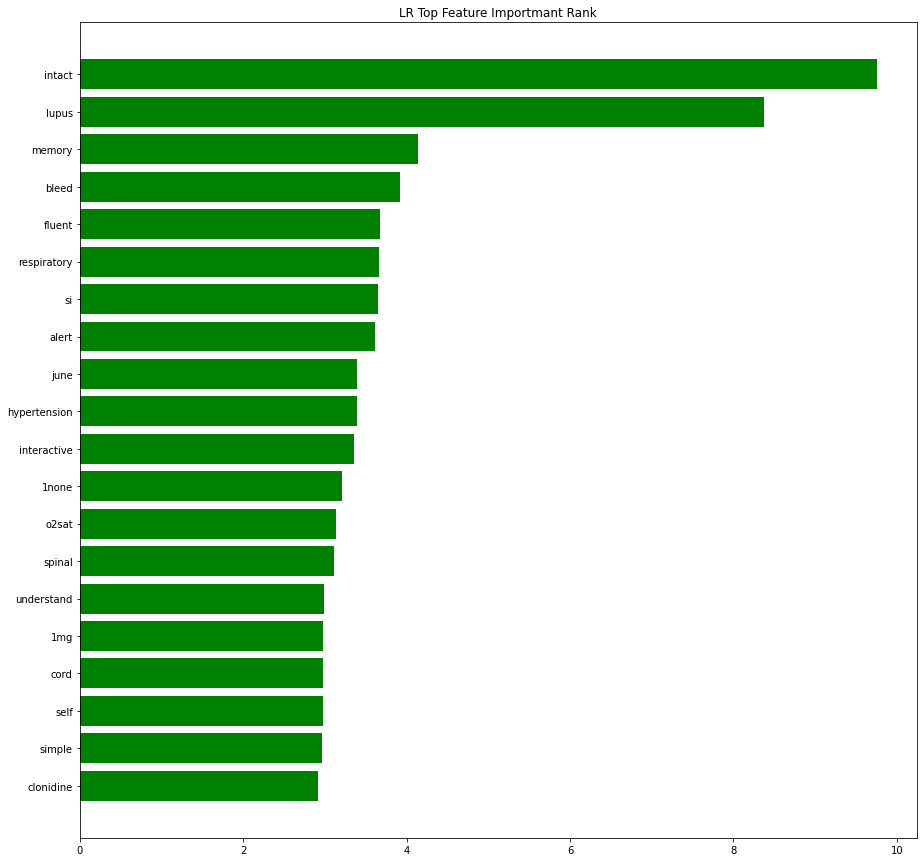

In [370]:
show_number = 20
lr_feature_names = list(filtered_tfidf_train.columns)
lr_feature_coef = list(lr.coef_.tolist()[0])
lr_feature_importance_df = pd.DataFrame(list(zip(lr_feature_names,lr_feature_coef)), columns = ['feature','lr_coef'])
lr_feature_importance_df = lr_feature_importance_df.sort_values('lr_coef',ascending=False)

plt.figure(figsize=(15,15))
plt.title("LR Top Feature Importmant Rank")
plt.gca().invert_yaxis()
plt.barh(lr_feature_importance_df[:show_number]['feature'], lr_feature_importance_df[:show_number]['lr_coef'], color='g')

## Analysis on Predictions

In [122]:
sample = pd.DataFrame(columns = ['patient_id', 'empi', 'label', 'apoe'])

In [124]:
sample['patient_id'] = df['PatientID']
sample['empi'] = df['EMPI']
sample['label'] = predictions

In [126]:
len(sample["patient_id"].unique())

13377

In [127]:
bib1 = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\BioBank\sd587_03212118253982866_6375194824947826181_Bib.csv")
bib2 = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\BioBank\sd587_03212118253982866_6375194824947826182_Bib.csv")

In [128]:
nodup = pd.read_csv(r"C:\Users\MIND_DS\Dropbox (Partners HealthCare)\NLP\BioBank\Partners_biobank_APOE_nodup.csv")

In [175]:
bib = pd.concat([bib1, bib2])

In [176]:
bib = bib.reset_index(drop = True)
nodup = nodup.reset_index(drop = True)

In [193]:
allele = str((nodup[nodup["subject_id"] == bib.loc[i]["Subject_Id"]]["APOE"].values))
allele = allele[2:len(allele)-2]
allele

'e2/e3'

In [179]:
bib = bib[bib['Subject_Id'].notna()]

In [194]:
apoe = []
for i in tqdm(range(len(bib))):
    allele = str((nodup[nodup["subject_id"] == bib.loc[i]["Subject_Id"]]["APOE"].values))
    allele = allele[2:len(allele)-2]
    apoe.append(allele)

100%|███████████████████████████████████████████████████████████████████████████| 37793/37793 [01:12<00:00, 522.85it/s]


In [180]:
len(bib)

37793

In [195]:
bib["APOE"] = apoe

In [196]:
bib.head()

,Registry_Name,Subject_Id,EMPI,EPIC_PMRN,MGH_MRN,BWH_MRN,FH_MRN,SRH_MRN,NWH_MRN,NSMC_MRN,MCL_MRN,MEE_MRN,DFC_MRN,WDH_MRN\n,APOE
0,Biobank,10070716,107184291,1.003113e+10,3512141.0,29632890.0,1306256.0,NaN,10356542.0,NaN,NaN,7621981.0,NaN,\n,e3/e4
1,Biobank,10060295,107092651,1.006235e+10,5953387.0,27702232.0,NaN,NaN,NaN,NaN,NaN,NaN,596421.0,\n,e3/e4
2,Biobank,10030565,107248715,1.006887e+10,6362516.0,28084887.0,NaN,NaN,NaN,10494629.0,NaN,NaN,NaN,\n,e3/e4
3,Biobank,10034983,107377411,1.003052e+10,5887395.0,NaN,NaN,NaN,395139.0,NaN,NaN,9414562.0,NaN,\n,e3/e3
4,Biobank,10038244,107494211,1.007376e+10,NaN,20961207.0,10149866.0,381049.0,NaN,NaN,NaN,9553597.0,628878.0,\n,e3/e3


In [197]:
apoe = []
for i in range(len(sample)):
    allele = bib[bib["EMPI"] == bib.loc[i]["EMPI"]]["APOE"].values
    apoe.append(allele)

In [198]:
sample["apoe"] = apoe

In [199]:
sample.head()

,patient_id,empi,label,apoe
0,Z6450279,100051335,Yes,[e3/e4]
1,Z6450779,100051533,Yes,[e3/e4]
2,Z6453461,100052395,Yes,[e3/e4]
3,Z6453666,100052451,NO,[e3/e3]
4,Z6454616,100052715,NO,[e3/e3]


In [200]:
convert = {2 : "Yes", 1 : "NTR", 0: "NO"}

In [201]:
# sample.label = [convert[i] for i in sample.label]

KeyError: 'Yes'

In [202]:
y = sample[sample["label"] == "Yes"]
ntr = sample[sample["label"] == "NTR"]
n = sample[sample["label"] == "NO"]

In [203]:
y["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             3520
[e3/e4]             1119
[e2/e3]              665
[e4/e4]              131
[e2/e4 or e1/e3]     110
[]                    41
[e2/e2]               30
Name: apoe, dtype: int64

In [204]:
n["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             6817
[e3/e4]             2259
[e2/e3]             1276
[e2/e4 or e1/e3]     237
[e4/e4]              234
[]                    60
[e2/e2]               54
Name: apoe, dtype: int64

In [206]:
ntr["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             2099
[e3/e4]              738
[e2/e3]              422
[e2/e4 or e1/e3]      81
[e4/e4]               69
[]                    21
[e2/e2]               17
Name: apoe, dtype: int64

In [208]:
ntr

,patient_id,empi,label,apoe
6,Z6456021,100053110,NTR,[e3/e4]
8,Z6456527,100053254,NTR,[e3/e3]
10,Z6457833,100053621,NTR,[e3/e4]
17,Z6467109,100056183,NTR,[e3/e3]
20,Z6473865,100057719,NTR,[e2/e2]
...,...,...,...,...
19971,Z13142079,110517265,NTR,[e2/e4 or e1/e3]
19975,Z7362609,102927269,NTR,[e2/e3]
19978,Z6499554,103901183,NTR,[e2/e3]
19983,Z8292638,106492605,NTR,[e3/e3]


In [207]:
sample["apoe"].value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[e3/e3]             12436
[e3/e4]              4116
[e2/e3]              2363
[e4/e4]               434
[e2/e4 or e1/e3]      428
[]                    122
[e2/e2]               101
Name: apoe, dtype: int64